# Trying to improve the accuracy using VGG16

The VGG16 architecture is a convolutional neural network (CNN) architecture that was first introduced by the Visual Geometry Group (VGG) at the University of Oxford in 2014.
The architecture consists of 13 convolutional layers and 3 fully connected layers, with a total of 138 million parameters. The convolutional layers are composed of 3x3 filters with a stride of 1 and a padding of 1, and are followed by rectified linear unit (ReLU) activation functions and 2x2 max pooling layers with a stride of 2.
The fully connected layers consist of 4096 units and use ReLU activation functions. The output layer consists of a softmax activation function that produces a probability distribution over the classes.
The VGG16 architecture was trained on the ImageNet dataset, which consists of over 1 million images and 1000 classes, and achieved state-of-the-art performance on this dataset. The architecture has since been widely used as a powerful and effective feature extractor for a variety of computer vision tasks, such as object recognition, image classification, and image segmentation.
The architecture's main advantage is its simplicity and its use of small filters with a shallow architecture that makes it easy to train and efficient in terms of computation.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# Define the relative paths to the dataset directories
train_dir = 'D:/Humber/Winter 23/Deep Learning/Project/ProjectDatasetImage/ProjectDatasetImage/Train/'
test_dir = 'D:/Humber/Winter 23/Deep Learning/Project/ProjectDatasetImage/ProjectDatasetImage/Test/'

In [4]:
# Set the batch size and number of epochs
batch_size = 32
epochs = 30

In [5]:
# Set the input shape of the images
input_shape = (80, 80, 3)

In [6]:
# Create the data generators with image augmentation and normalization
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

Found 5109 images belonging to 5 classes.
Found 1273 images belonging to 5 classes.
Found 2732 images belonging to 5 classes.


In [7]:
# generate the first batch of images from the train generator
x_batch, y_batch = train_generator.next()

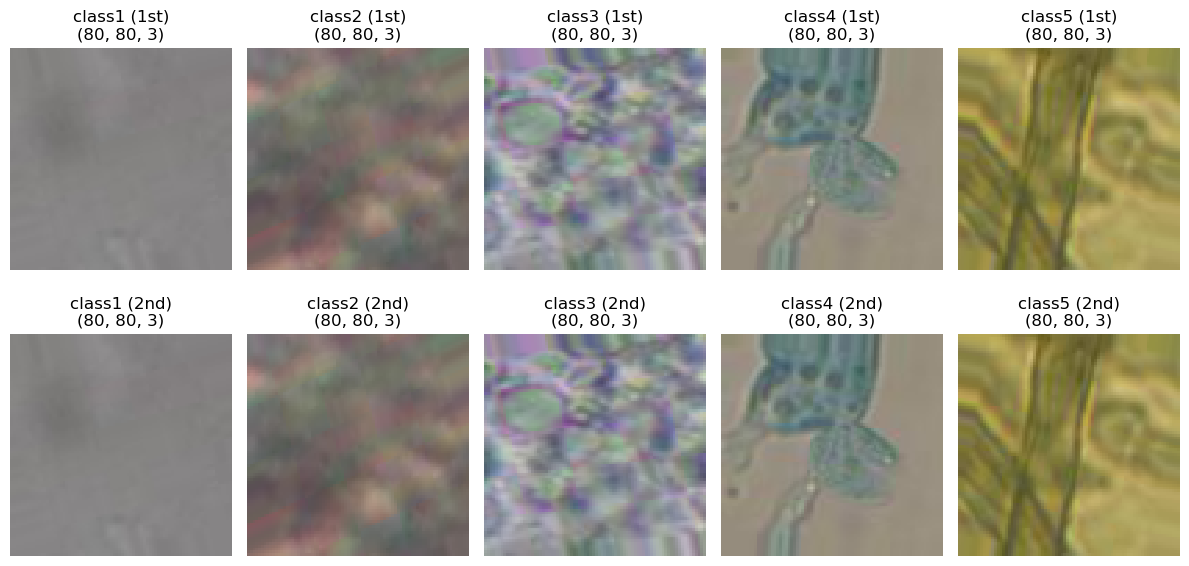

In [8]:
# Define the class names as a list
class_names = ['class1', 'class2', 'class3', 'class4', 'class5']

# Generate the first batch of images and labels from the train generator
x_batch, y_batch = train_generator.next()

# Create a figure with 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6), dpi=100)
fig.subplots_adjust(hspace=0.5, wspace=0.2)

# Create a dictionary to keep track of the indices of each class in the batch
class_indices = {}
for i in range(len(class_names)):
    class_indices[i] = []

# Add the index of each image to its corresponding class in the dictionary
for i in range(len(x_batch)):
    class_indices[y_batch[i].argmax()].append(i)

# Plot two random images from each class
for i in range(len(class_names)):
    row = i // 5
    col = i % 5
    if len(class_indices[i]) > 0:
        idx1 = class_indices[i][np.random.randint(len(class_indices[i]))]
        ax1 = axes[row, col]
        ax1.imshow(x_batch[idx1], interpolation='nearest')
        ax1.set_title(f"{class_names[i]} (1st)\n{str(x_batch[idx1].shape)}")
        ax1.axis('off')

        idx2 = class_indices[i][np.random.randint(len(class_indices[i]))]
        ax2 = axes[row + 1, col]
        ax2.imshow(x_batch[idx2], interpolation='nearest')
        ax2.set_title(f"{class_names[i]} (2nd)\n{str(x_batch[idx2].shape)}")
        ax2.axis('off')

plt.tight_layout()
plt.show()


In [9]:
# Create the model with transfer learning and early stopping callbacks
base_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=input_shape,
    weights='imagenet',
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax'),
])

model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
)

mc_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
)

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[es_callback, mc_callback],
)

Epoch 1/30
160/160 [==============================] - ETA: 0s - loss: 1.0489 - accuracy: 0.5827
Epoch 1: val_loss improved from inf to 0.95504, saving model to best_model.h5
160/160 [==============================] - 51s 315ms/step - loss: 1.0489 - accuracy: 0.5827 - val_loss: 0.9550 - val_accuracy: 0.5994
Epoch 2/30
160/160 [==============================] - ETA: 0s - loss: 0.8927 - accuracy: 0.6485
Epoch 2: val_loss did not improve from 0.95504
160/160 [==============================] - 47s 295ms/step - loss: 0.8927 - accuracy: 0.6485 - val_loss: 0.9897 - val_accuracy: 0.5986
Epoch 3/30
160/160 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.6721
Epoch 3: val_loss did not improve from 0.95504
160/160 [==============================] - 48s 298ms/step - loss: 0.8296 - accuracy: 0.6721 - val_loss: 0.9808 - val_accuracy: 0.5711
Epoch 4/30
160/160 [==============================] - ETA: 0s - loss: 0.8021 - accuracy: 0.6808
Epoch 4: val_loss did not improve from 0.9

In [10]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

86/86 [==============================] - 19s 221ms/step - loss: 0.7788 - accuracy: 0.6852
Test accuracy: 0.6852123141288757


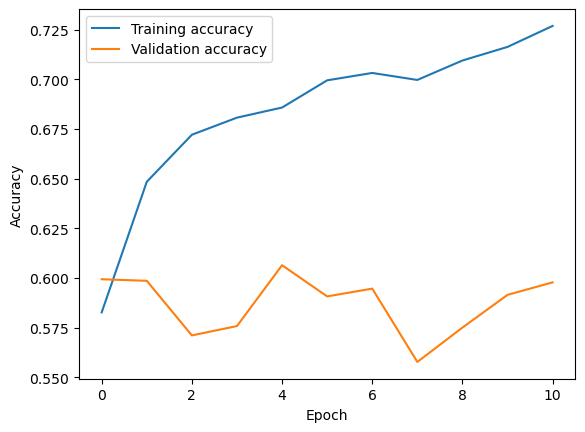

In [11]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 41ms/step


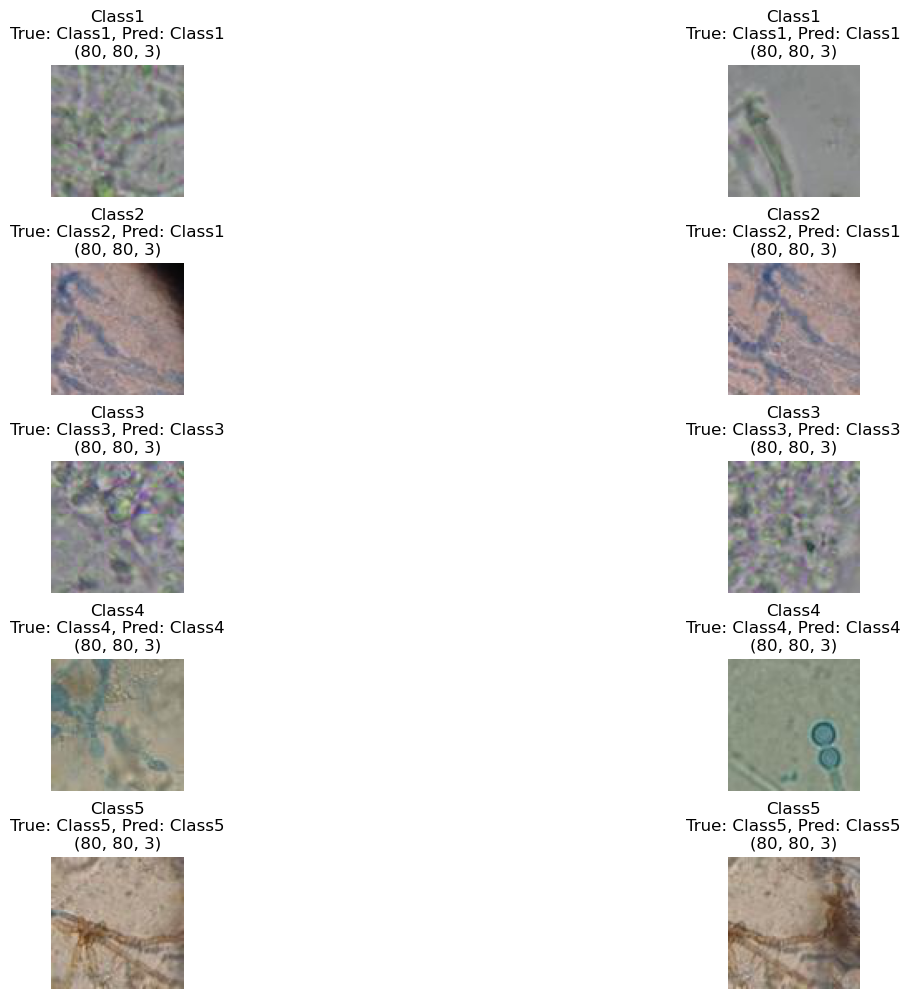

In [12]:
%matplotlib inline
class_names = list(train_generator.class_indices.keys())
num_images_per_class = 2

fig, axes = plt.subplots(len(class_names), num_images_per_class, figsize=(16, 12), dpi=100)
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(test_dir, class_name)
    class_images = os.listdir(class_dir)[:num_images_per_class]
    for j, image_name in enumerate(class_images):
        image_path = os.path.join(class_dir, image_name)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
        image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.
        image_array = np.expand_dims(image_array, axis=0)
        y_true = np.zeros((1, train_generator.num_classes))
        y_true[0, train_generator.class_indices[class_name]] = 1
        y_pred = model.predict(image_array)[0]
        y_true_name = class_name
        y_pred_name = class_names[np.argmax(y_pred)]
        ax = axes[i, j]
        ax.imshow(image_array[0])
        ax.set_title(f"{class_name}\nTrue: {y_true_name}, Pred: {y_pred_name}\n{str(image_array[0].shape)}")
        ax.axis('off')
plt.show()


# Overall Conclusion

In this code, we trained a CNN model and a VGG16 model on a dataset of images with multiple classes. Both models were trained using image augmentation and normalization techniques. The VGG16 model used transfer learning, where the pre-trained weights from the ImageNet dataset were used as initial weights for the model. The CNN model was trained from scratch.

After training both models, we evaluated their performance on a test set and plotted their training and validation accuracy over the epochs. The VGG16 model achieved a higher test accuracy than the CNN model, indicating that transfer learning with a pre-trained model can be a powerful technique for improving model performance on image classification tasks.

Overall, this code demonstrates the effectiveness of using a pre-trained model like VGG16 for image classification tasks, and the importance of using techniques like image augmentation and normalization to improve model performance. By using the VGG16 model, we were able to achieve a higher accuracy compared to the CNN model.